In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import h5py
from keras.models import load_model

cell = 'IMR90'  # HeLa-S3  HUVEC

file_name_cell = '../' + cell + '_all_data_hilbert_without_aug.h5'  # _hilbert_aug _origin
with h5py.File(file_name_cell, 'r') as hf:
    dataset_enhancer = np.array(hf.get('enhancers'))
    dataset_promoter = np.array(hf.get('promoters'))
    labels = np.array(hf.get('labels'))

pos = 0
for i in range(len(labels)):
    if labels[i] == 1:
        pos += 1

pos_enh = dataset_enhancer[:pos]
pos_pro = dataset_promoter[:pos]

pos_enh.shape

Using TensorFlow backend.


(1254, 64, 64, 4)

In [2]:
model = load_model('../%s_bestmodel.h5' % cell)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   6464        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   6464        input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [32]:
from keras.models import Model

def get_sequence(index):
    enh = np.array(pos_enh[index])
    pro = np.array(pos_pro[index])

    conv2d_enh = Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
    conv2d_pro = Model(inputs=model.input,outputs=model.get_layer('conv2d_4').output)
    enh = np.expand_dims(enh, axis=0) # 升高维度 64*64*4 至 1*64*64*4
    pro = np.expand_dims(pro, axis=0)
    enhancer_output = conv2d_enh.predict([enh,pro])
    promoter_output = conv2d_pro.predict([enh,pro])
    
    enhancer_output=np.squeeze(enhancer_output)  # 64*64*4
    enh=np.squeeze(enh)  # 4*4*128
    promoter_output=np.squeeze(promoter_output)  # 64*64*4
    pro=np.squeeze(pro)  # 降低维度 1*4*4*128至4*4*128 
    
    return enh,pro,enhancer_output,promoter_output

In [33]:
enh,pro,enh_out,pro_out = get_sequence(40)

In [34]:
def plt_show_prepare(input_s,output_s):
    temp_input1 = input_s[:,:,0]
    temp_input2 = input_s[:,:,1]
    temp_input3 = input_s[:,:,2]
    temp_input4 = input_s[:,:,3]
    temp_output = np.zeros((4,4))

    for i in range(128):
        temp_output += output_s[:,:,i]

    temp_output = temp_output.astype(np.uint8)
    temp_output = temp_output/np.max(temp_output)
    
    return temp_input1,temp_input2,temp_input3,temp_input4,temp_output

In [35]:
temp_input1,temp_input2,temp_input3,temp_input4,temp_output = plt_show_prepare(enh,enh_out)

In [40]:
def plt_show(name):
    plt.imshow(name,cmap='gray')
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.show()

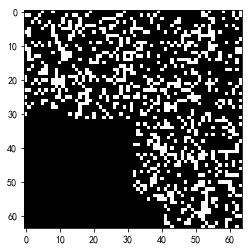

In [44]:
plt_show(temp_input4)

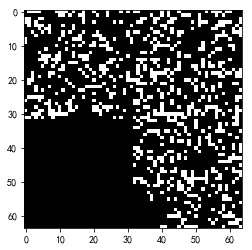

In [45]:
plt_show(temp_input2)

In [47]:
temp_input1.shape

(64, 64)

In [48]:
temp_output

array([[0.6, 0.8, 0.7, 0.6],
       [0.6, 1. , 1. , 0.9],
       [0.4, 0.6, 0.8, 0.8],
       [0. , 0.2, 0.5, 0.6]])

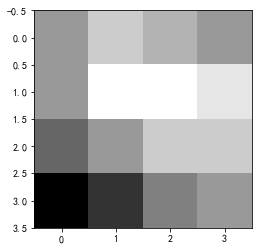

In [49]:
plt_show(temp_output)

In [51]:
enh_out.shape

(4, 4, 128)

In [54]:
enh_out[:,:,2]

array([[0.07863908, 0.06861991, 0.03411293, 0.        ],
       [0.12628329, 0.14753903, 0.19317919, 0.08543525],
       [0.11437594, 0.17230819, 0.        , 0.14232774],
       [0.        , 0.04484231, 0.20558703, 0.16227321]], dtype=float32)